# <span style="color:#9c8f8f"> 75.06/95.58 Organización de Datos</span>
# <span style="color:#9c8f8f"> Análisis exploratorio: Real or Not? NLP with Disaster Tweets</span>

# <center>FEATURE ENGINEERING</center>
# <center>LightGBM</center>

In [253]:
# Cargo librerias
import pandas as pd
import numpy as np
import itertools
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import nbimporter

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import RandomizedSearchCV

In [254]:
# Cargo train and test

dtype_train = {"id": np.int32, "keyword": "category", "target" : int}
train = pd.read_csv("original_data/train.csv", dtype = dtype_train, encoding='UTF_8')

In [255]:
# Creo dataframe con target

target_train = train[["id","target"]]

In [256]:
DIR_CSV = "features/"

# I) Understanding LightGBM

# II) Auxiliary Functions

In [257]:
dtype_train = {"id": np.int32, "keyword": "category", "target" : int}
train = pd.read_csv("original_data/train.csv", dtype = dtype_train, encoding='UTF_8')

target_train = train[["id","target"]]
    
def get_clean_values(df):
    
    if("target" in list(df.columns)):
        del df["target"]
    df = df.merge(target_train, how="inner", on="id")   
    
    X = df.copy().fillna(0)
    y = df["target"].copy()
    
    if("target" in list(X.columns)):
        del X['target']
    if("id" in list(X.columns)):
        del X['id']
    if("Unnamed: 0" in list(X.columns)):
        del X["Unnamed: 0"]
    
    return X,y

In [258]:
def lightgbm_regressor_feature_search(X,y,m):
    
    # Model creation
    # Parameter tuning for each file of features
    lgbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='accuracy')
    random_grid = {'num_leaves': np.arange(25,70,4),
               'learning_rate':[0.005,0.01,0.05,0.1,0.3],
               'n_estimators': np.arange(25,200,15),
               'max_depth': np.arange(5,13,1),
               'min_split_gain': [0.001,0.01,0.1,0.2],
               'bagging_fraction': np.arange(0.8,1.01,0.1),
               'feature_fraction': np.arange(0.1,0.91,0.2)}
    lgbm_random= RandomizedSearchCV(estimator = lgbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1, scoring= 'accuracy')
    lgbm = lgbm_random.fit(X, y)

    # Model creation with best parameters
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=50)
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_valid = lgb.Dataset(X_val, label=Y_val)
    watchlist = [d_valid]
    lgbm = lgb.train(lgbm_random.best_params_, d_train, n_estimators, watchlist, verbose_eval=False)
    
    # Feature importance
    feature_importances = lgbm.feature_importance()
    
    # get index of m most important features sorted
    m_index = np.argpartition(feature_importances, -m)[-m:]
    m_index = m_index[np.argsort(feature_importances[m_index])][::-1]
    
    # Get the m most important features of locations
    m_feature_importances = feature_importances[m_index]
    
    # Get m feature name
    m_feature_name = X.columns[m_index]
    
    return feature_importances, m_index, m_feature_importances, m_feature_name

In [259]:
# m cantidad de features con más relevancia

def lightgbm_regressor_files(previous_dir, files, m_value):
    
    # contiene una lista por archivo con feature_importances, m_index, m_feature_importances, m_feature_name
    locations_others_info = []
    
    for i in range(len(files)):
        
        # cargo archivo
        df = pd.read_csv(previous_dir + files[i], low_memory=False)

        # Separo mi data
        X, y = get_clean_values(df)
        
        # Verifico m
        m = m_value if (m_value < len(X.columns)) else len(X.columns)

        # Aplico desition tree
        feature_importances, m_index, m_feature_importances, m_feature_name = lightgbm_regressor_feature_search(X,y,m)
        locations_others_info.append([feature_importances, m_index, m_feature_importances, m_feature_name])

        # Imprimo informacion
        print_feature_search(m_feature_name, m_feature_importances, files[i])
        plotImp(m_feature_name, m_feature_importances, 'LightGBM', 25, lgb=True)
    
    return locations_others_info

In [260]:
def print_feature_search(feature, importance, file):
    
    print("{}\n".format(file.upper()))
    print("{: >20} {: >20}\n".format("feature","importance"))
    for i in range(len(feature)):
        print("{: >20}\t\t{: >20}".format(feature[i],importance[i]))
    print("\n\n")

In [261]:
def plotImp(feature, importance , name, num=25, lgb=False, ci=False):
    feature_imp = pd.DataFrame({'Value':importance,'Feature':feature})
    
    tamanio_vertical = (num)/(2*1.2)

    plt.figure(figsize=(18, tamanio_vertical))
    
    #sns.set(font_scale = 3)
    rot = [-.75, -.5, -.25, 0, .25, .5, .75]
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
                palette=sns.cubehelix_palette(num, start=0, rot=random.choice(rot), reverse=True))
    
    titulo = name+" Top Feature Importances"
    if ci:
        titulo+= " (post Cumulative Importance)"
    plt.title(titulo, fontsize=20)
    plt.xlabel("Importance", fontsize=18)
    plt.ylabel("Feature", fontsize=18)
    plt.tick_params(grid_alpha=0.5, labelsize=15)
   
    plt.tight_layout()
#    if not ci:
#        file = name.lower()+"_feature_importance.png"
#    else:
#        file = name.lower()+"_ci_feature_importance.png"
#    plt.savefig(file)
    plt.show()

# III) LightGBM

In [262]:
m = 40

## 1. Keywords

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_KEYWORDS_IN_TEXT_ENCODED.CSV

             feature           importance

              K_fire		                  55
             K_storm		                  47
          K_wreckage		                  37
          K_collapse		                  36
         K_oil spill		                  35
       K_mass murder		                  34
              K_bomb		                  34
          K_disaster		                  34
            K_debris		                  33
         K_terrorism		                  33
          K_casualty		                  33
          K_evacuate		                  32
            K_hijack		                  32
           K_typhoon		                  32
             K_crash		                  31
              K_hail		                  30
              K_burn		                  30
           K_refugee		                  29
             K_death		                  29
            K_famine		                  28
        K_earthquake		                  28
             K_

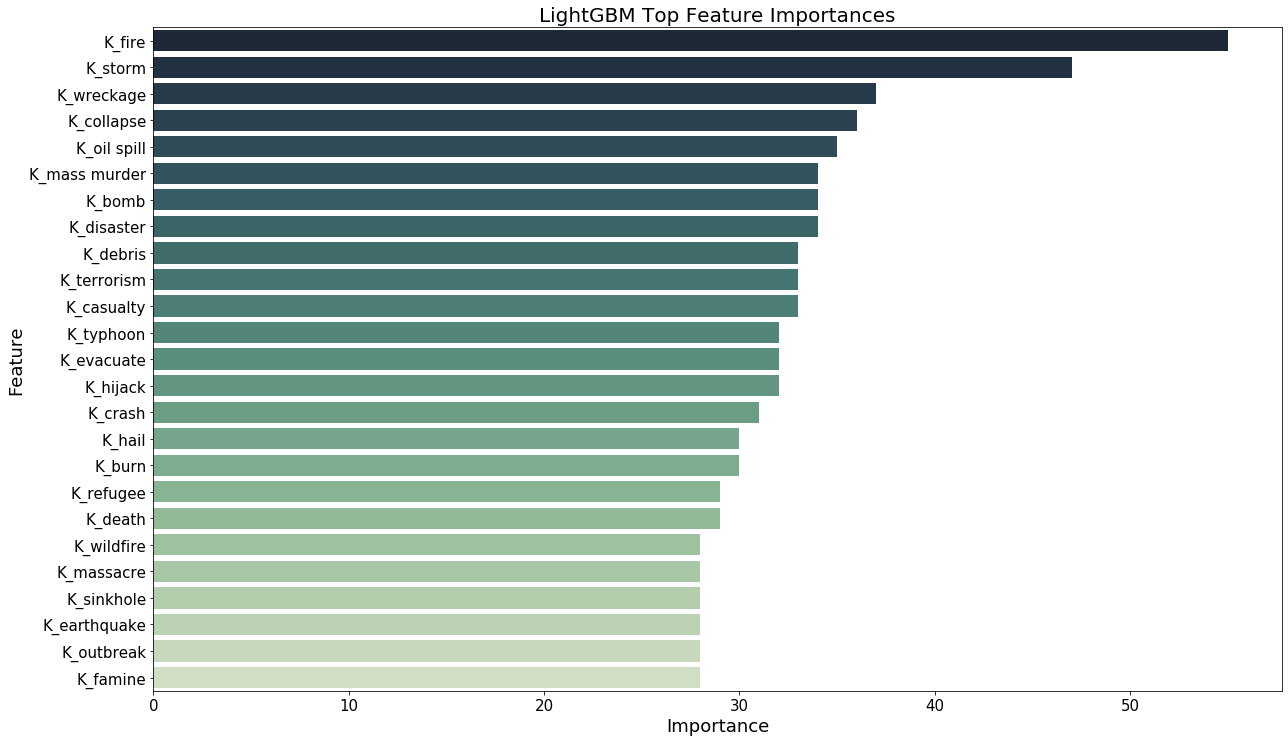

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_KEYWORDS_NUMERICAL.CSV

             feature           importance

   keyword_frequency		                 913
   keywords_quantity		                 191
       keywords_mean		                 183
text_contains_keyword		                  53
  keyword_is_hashtag		                  13
         has_keyword		                   0





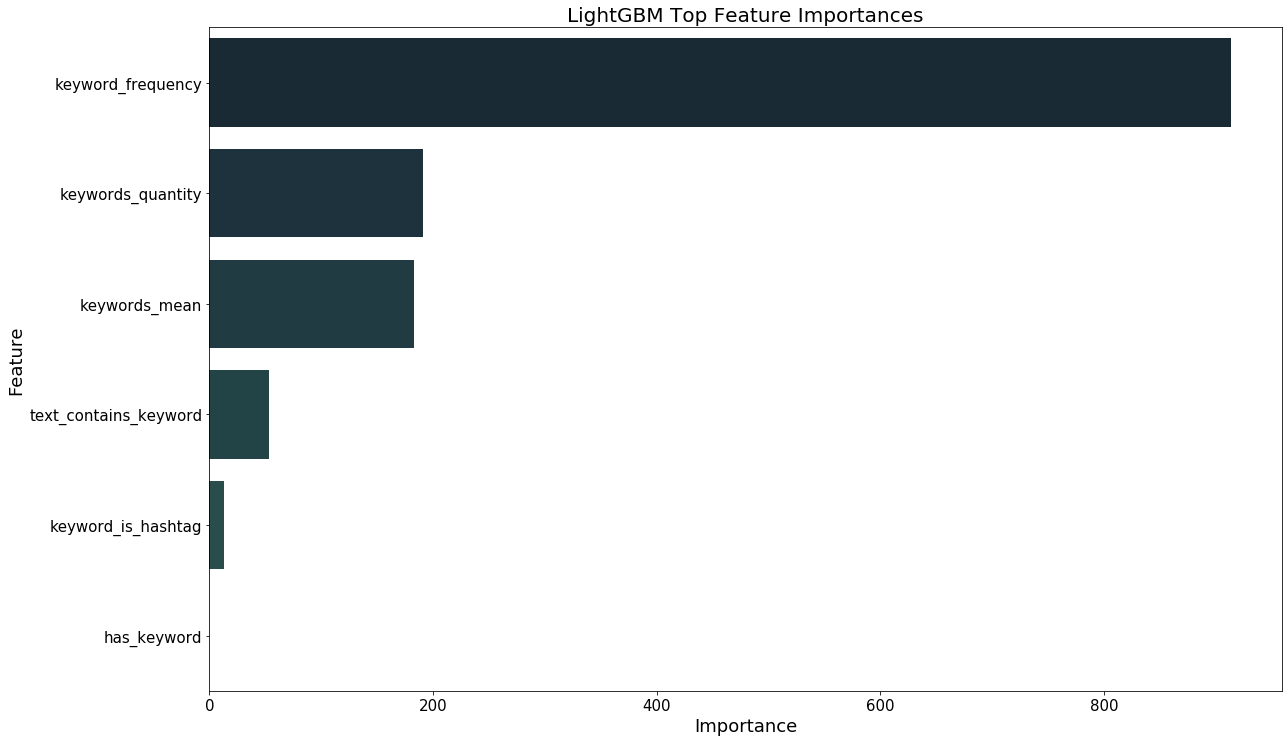

In [263]:
files_keywords = ["features_keywords_in_text_encoded.csv", "features_keywords_numerical.csv"]
LGB_keywords = lightgbm_regressor_files(DIR_CSV + 'train/' ,files_keywords, m)

## 2. Text 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_TAGGED.CSV

             feature           importance

             youtube		                 164
         examinercom		                   0
           evebrigid		                   0
         evahanderek		                   0
             evacide		                   0
             evaaasr		                   0
                euro		                   0
        eunice_njoki		                   0
            etribune		                   0
          ethereal_7		                   0
           zxathetis		                   0
        essexweather		                   0
       esquireattire		                   0
               erker		                   0
      erinmariefishy		                   0
          fevwarrior		                   0
           eileenmfl		                   0
         erasuterism		                   0
      ellenfromnowon		                   0
     estellasrevenge		                   0
            expirehc		                   0
     femalegilgamesh		           

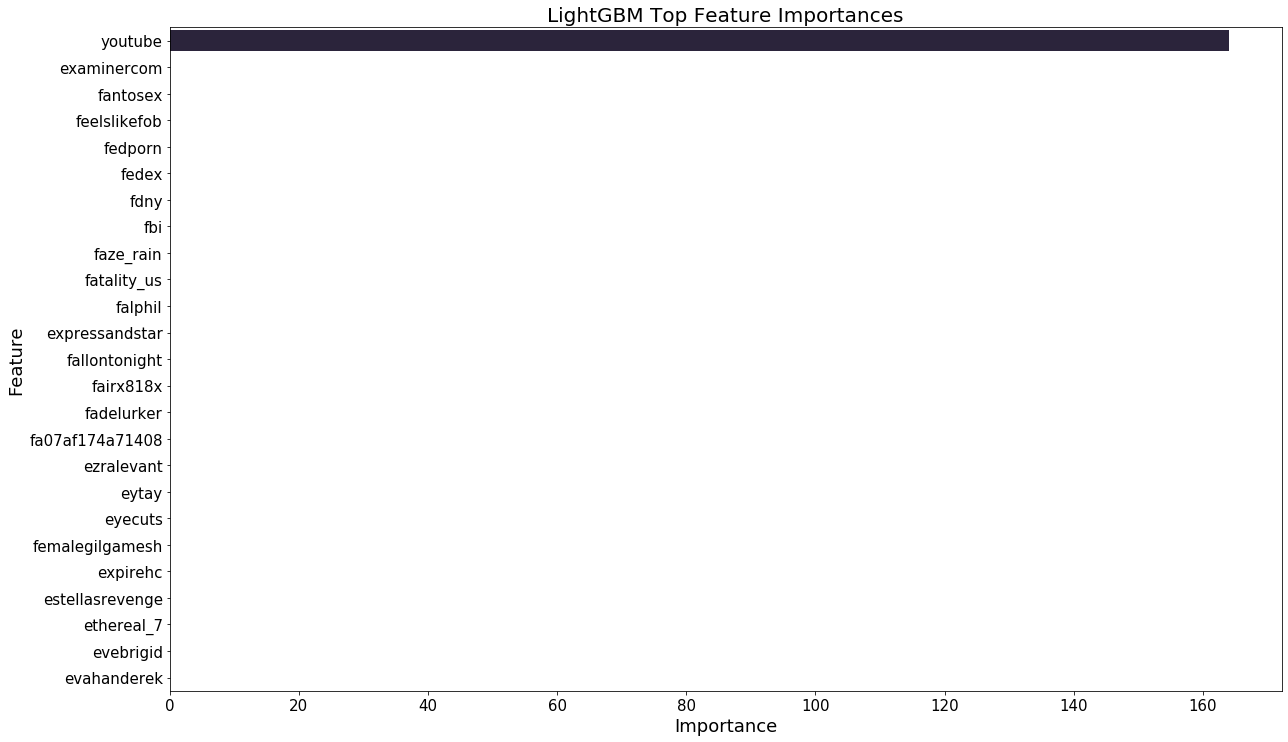

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_TAGGED_SMOOTH.CSV

             feature           importance

             youtube		                 164
         examinercom		                   0
           evebrigid		                   0
         evahanderek		                   0
             evacide		                   0
             evaaasr		                   0
                euro		                   0
        eunice_njoki		                   0
            etribune		                   0
          ethereal_7		                   0
           zxathetis		                   0
        essexweather		                   0
       esquireattire		                   0
               erker		                   0
      erinmariefishy		                   0
          fevwarrior		                   0
           eileenmfl		                   0
         erasuterism		                   0
      ellenfromnowon		                   0
     estellasrevenge		                   0
            expirehc		                   0
     femalegilgamesh		    

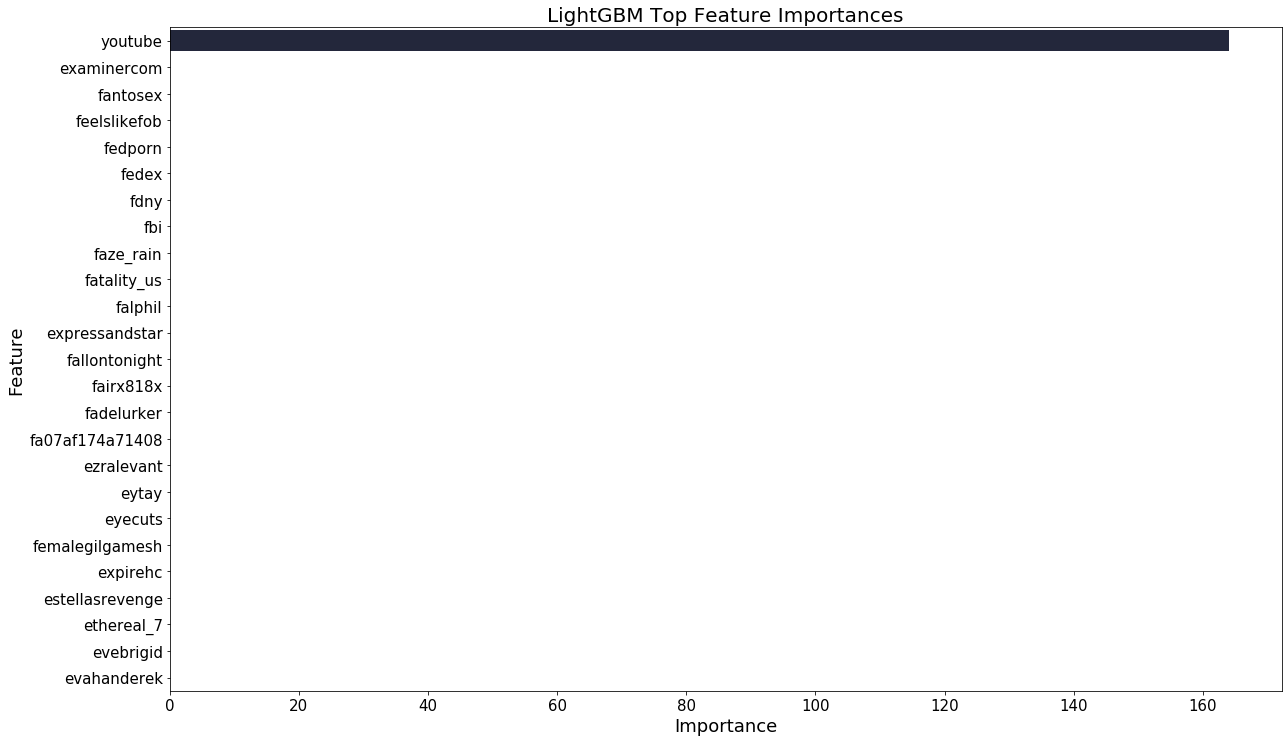

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_HASHTAGS.CSV

             feature           importance

                news		                 151
           hiroshima		                  73
    zombiefunrun2014		                   0
              forbes		                   0
             foxnews		                   0
  foxdebatequestions		                   0
           fortworth		                   0
               forex		                   0
             forever		                   0
               funds		                   0
               flood		                   0
              france		                   0
    flavorchargedtea		                   0
           flattened		                   0
          flashflood		                   0
            flooding		                   0
                fiya		                   0
              forest		                   0
        firstnations		                   0
                  fr		                   0
    francisunderwood		                   0
                 fun		         

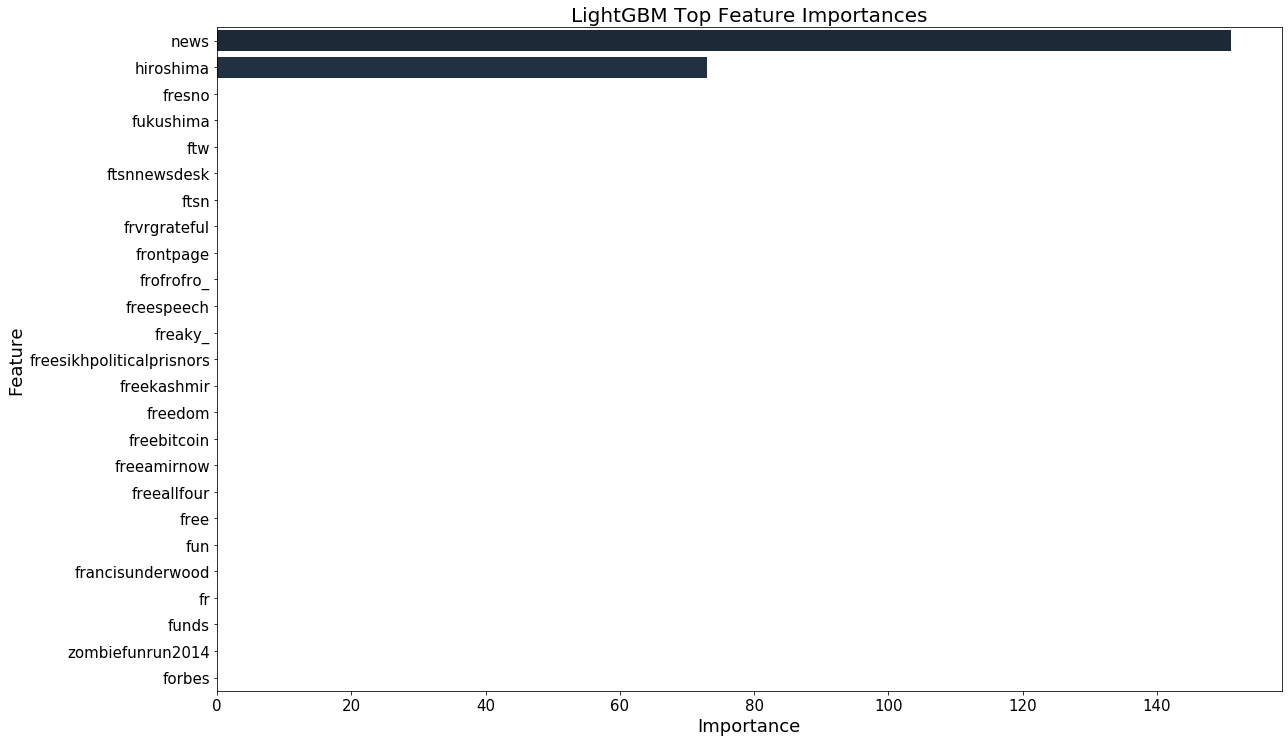

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_HASHTAGS_SMOOTH.CSV

             feature           importance

                news		                 151
           hiroshima		                  73
    zombiefunrun2014		                   0
              forbes		                   0
             foxnews		                   0
  foxdebatequestions		                   0
           fortworth		                   0
               forex		                   0
             forever		                   0
               funds		                   0
               flood		                   0
              france		                   0
    flavorchargedtea		                   0
           flattened		                   0
          flashflood		                   0
            flooding		                   0
                fiya		                   0
              forest		                   0
        firstnations		                   0
                  fr		                   0
    francisunderwood		                   0
                 fun		  

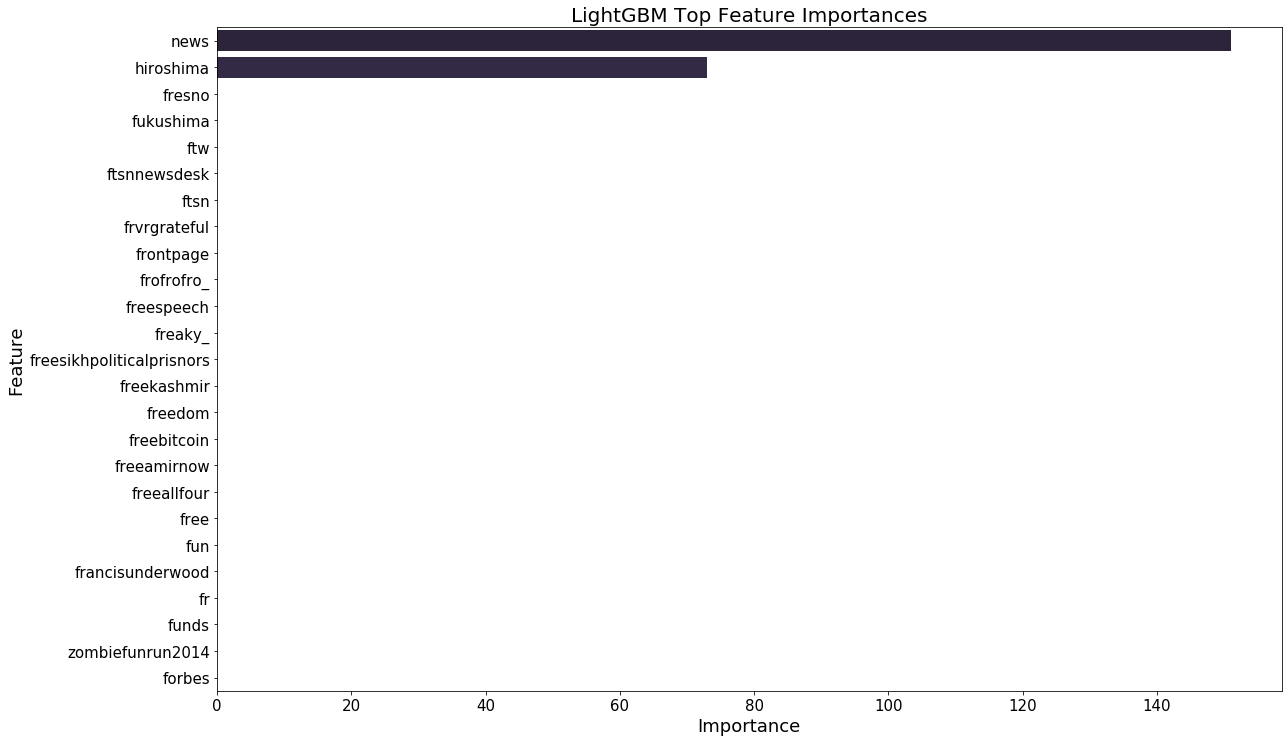

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_TEXT_NUMERICAL.CSV

             feature           importance

   promedio_len_word		                 886
         #caracteres		                 740
            #silabas		                 555
         #capitalize		                 432
         #puntuacion		                 378
          #stopwords		                 356
           #palabras		                 306
         #mayusculas		                 299
    #palabras_unicas		                 285
#caracteres_especiales		                 229
  #caracteres_binned		                  77
  #puntuacion_binned		                  62
     #silabas_binned		                  61
  #capitalize_binned		                  60
#palabras_unicas_binned		                  37
   #stopwords_binned		                  37
    #palabras_binned		                  27
#caracteres_especiales_binned		                  15
  #mayusculas_binned		                   0





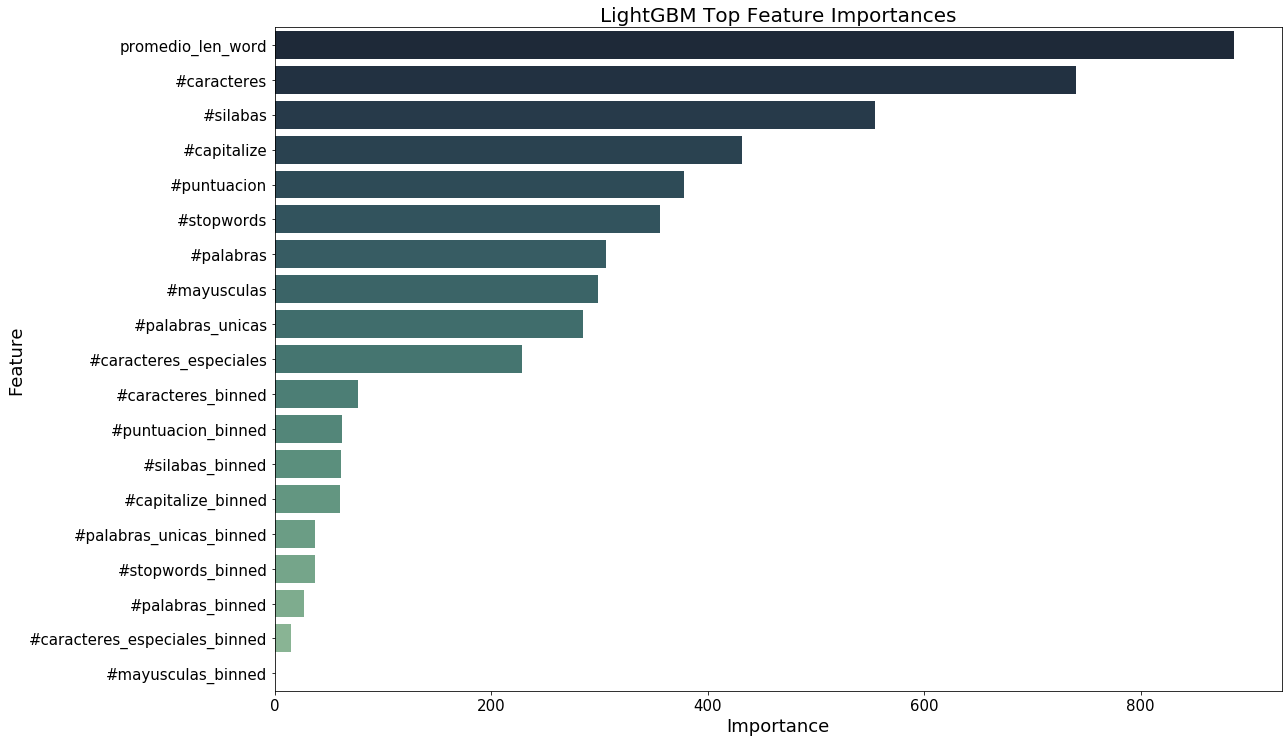

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    9.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_ARROBAS_NUMERICAL.CSV

             feature           importance

       #tagged_users		                 442





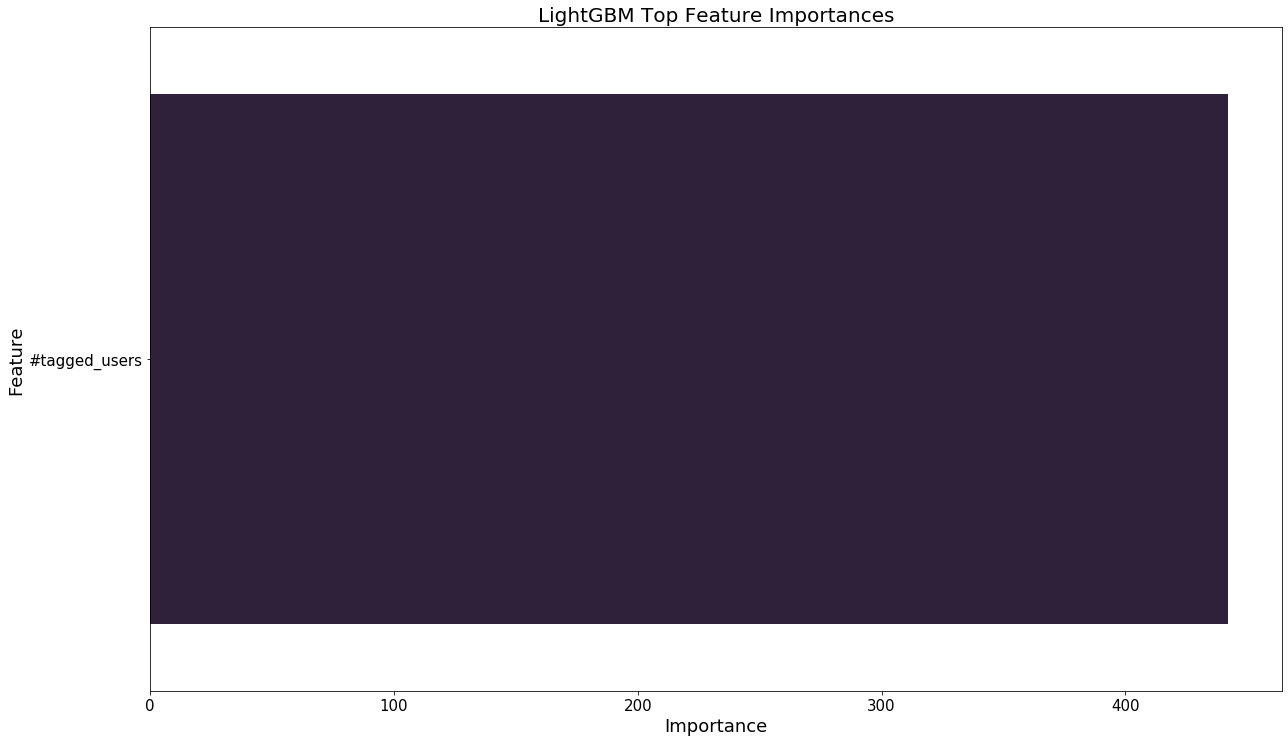

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_HASHTAGS_NUMERICAL.CSV

             feature           importance

           #hashtags		                 556
         has_hashtag		                   0





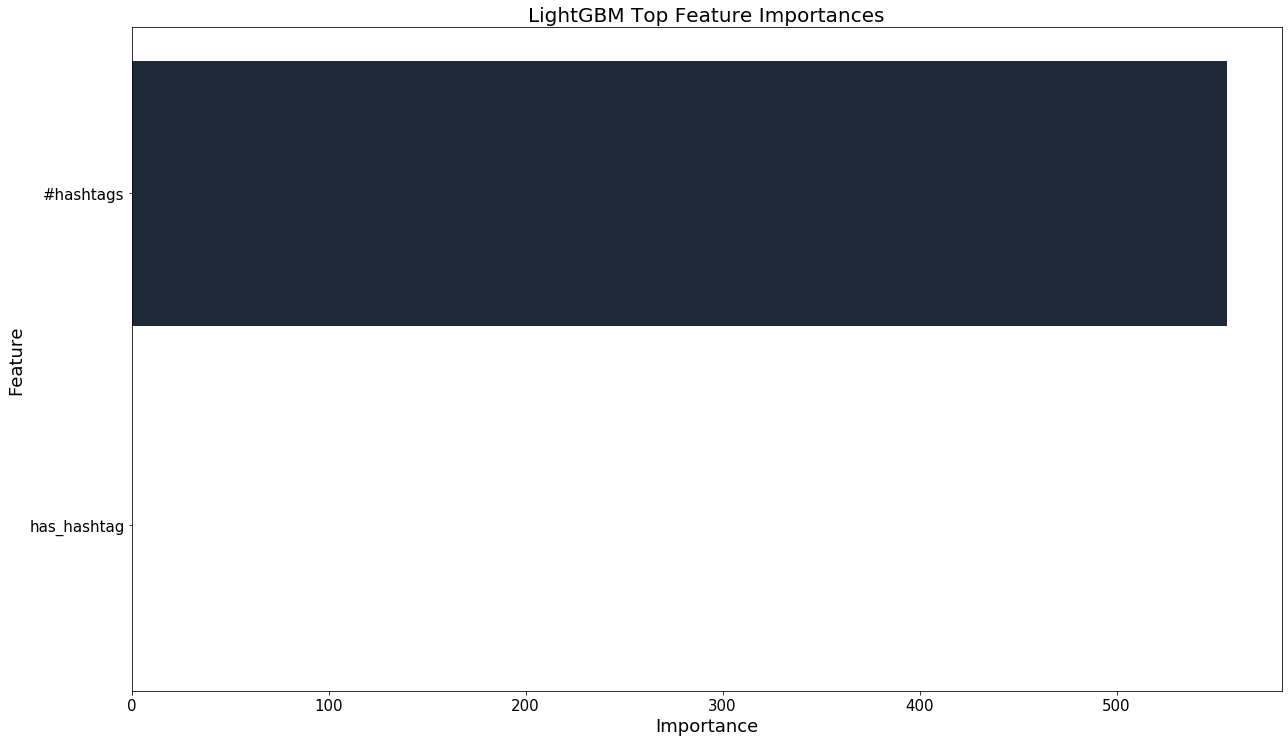

In [265]:
files_text = [
    'features_tagged.csv',
    'features_tagged_smooth.csv',
    'features_hashtags.csv',
    'features_hashtags_smooth.csv',
    'features_text_numerical.csv',
    'features_arrobas_numerical.csv',
    'features_hashtags_numerical.csv'
]

LGB_text = lightgbm_regressor_files(DIR_CSV + 'train/', files_text, m)

## 3. Locations

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_LOCATION_NUMERICAL.CSV

             feature           importance

       has_continent		                  28
            has_city		                  22
           has_state		                  11
          has_county		                   0
         has_country		                   0





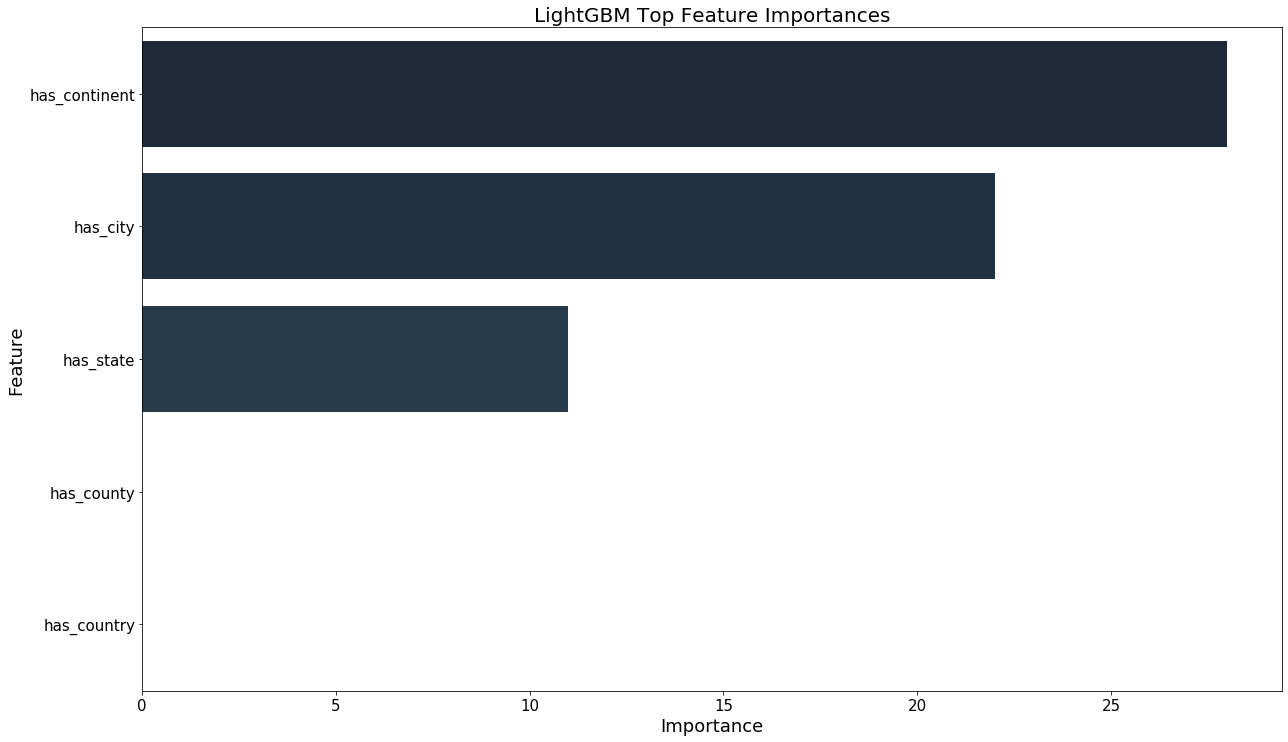

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_LOCATION_IN_TEXT_NUMERICAL.CSV

             feature           importance

       has_continent		                  74
         has_country		                  57
            has_city		                  57
           has_state		                  56
          has_county		                  14





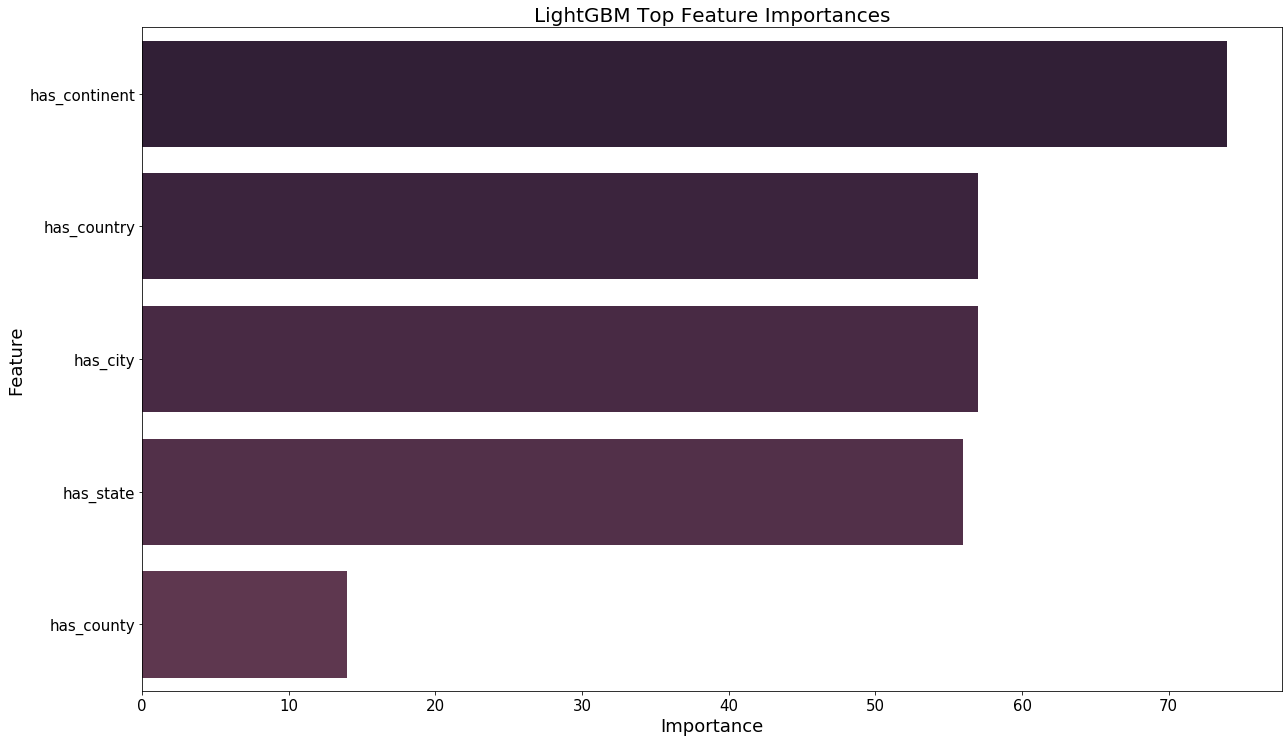

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_LOCATION_IN_TEXT_NUMERICAL.CSV

             feature           importance

       has_continent		                  74
         has_country		                  57
            has_city		                  57
           has_state		                  56
          has_county		                  14





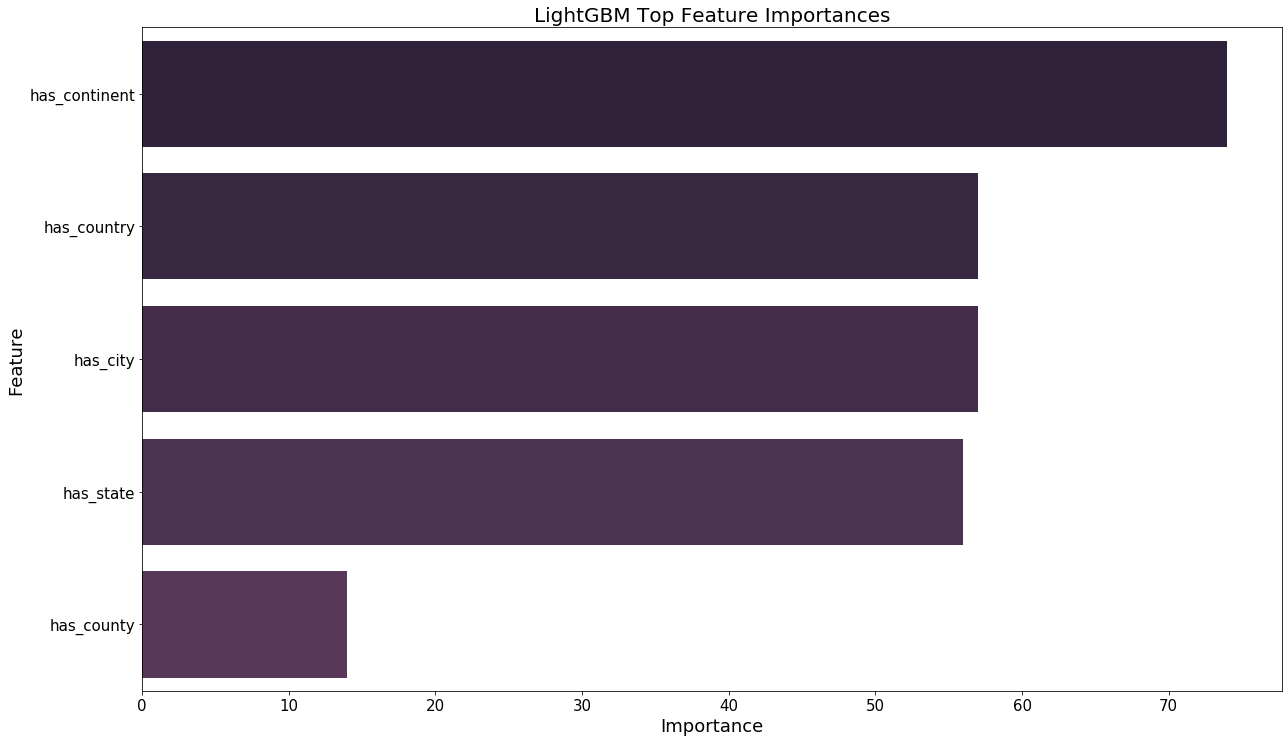

In [266]:
files_location = [
    #'features_location_bow.csv',
    #'features_location_tf_idf.csv',
    'features_location_numerical.csv',
    'features_location_in_text_numerical.csv',
    'features_location_in_text_numerical.csv'
]

LGB_location = lightgbm_regressor_files(DIR_CSV + 'train/' , files_location, 10)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_CITY_ENCODED.CSV

             feature           importance

     city_Washington		                  34
        city_Florida		                  34
        city_Chicago		                  31
         city_Mumbai		                  28
           city_York		                  26
         city_London		                  25
          city_Texas		                  22
       city_Zaragoza		                   0
     city_Fort Wayne		                   0
      city_Frankfort		                   0
city_Fountain Valley		                   0
     city_Fort Worth		                   0
     city_Fort Myers		                   0
     city_Fort Smith		                   0
       city_Freeport		                   0
city_Fort Lauderdale		                   0
   city_Fort Collins		                   0
      city_Guayaquil		                   0
        city_Fairfax		                   0
         city_Durham		                   0
       city_Dunwoody		                   0
       city_Frascati		     

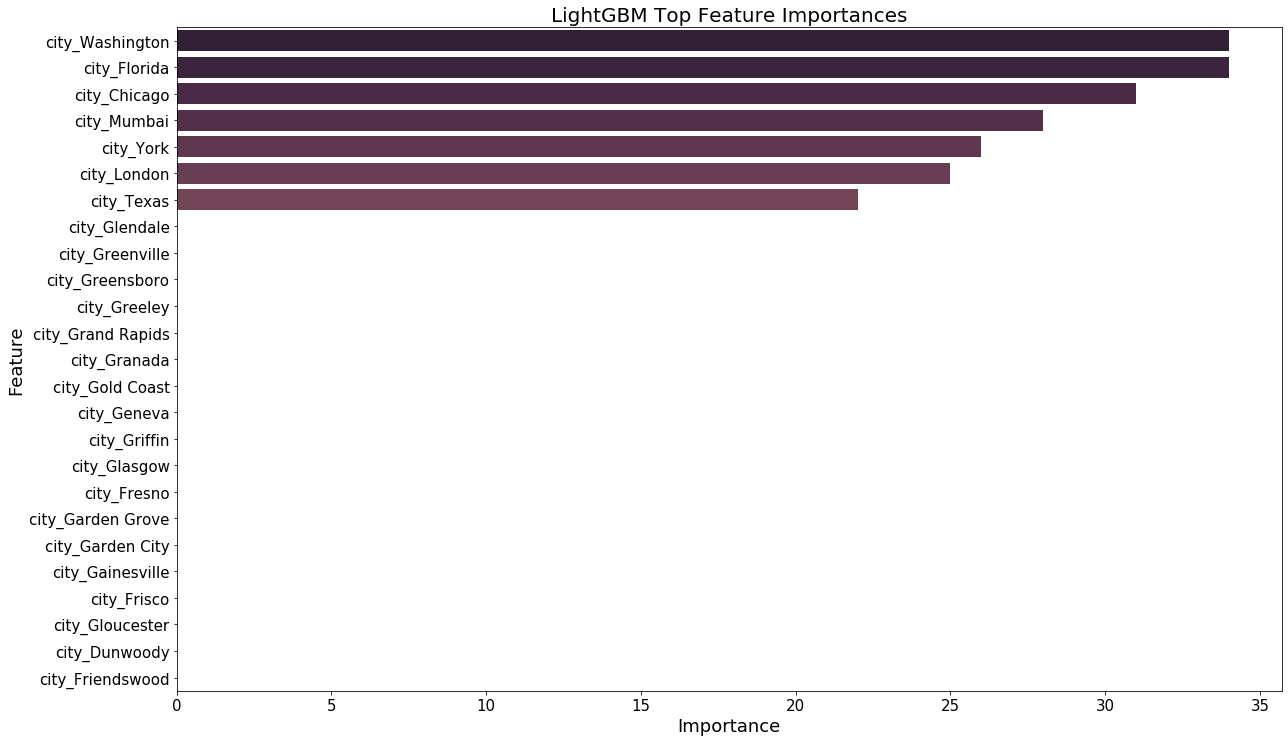

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_CITY_IN_TEXT_ENCODED.CSV

             feature           importance

          city_Young		                   0
   city_Forest Hills		                   0
        city_Liberal		                   0
      city_Leicester		                   0
          city_Leeds		                   0
         city_Latina		                   0
           city_Kyle		                   0
   city_Kuala Lumpur		                   0
city_Hoffman Estates		                   0
           city_Holt		                   0
         city_Khulna		                   0
      city_Jefferson		                   0
   city_Johannesburg		                   0
        city_Krefeld		                   0
           city_Kiev		                   0
       city_Kamloops		                   0
        city_Karachi		                   0
         city_Kaduna		                   0
        city_Jupiter		                   0
         city_London		                   0
city_Huntington Park		                   0
     city_Long Beac

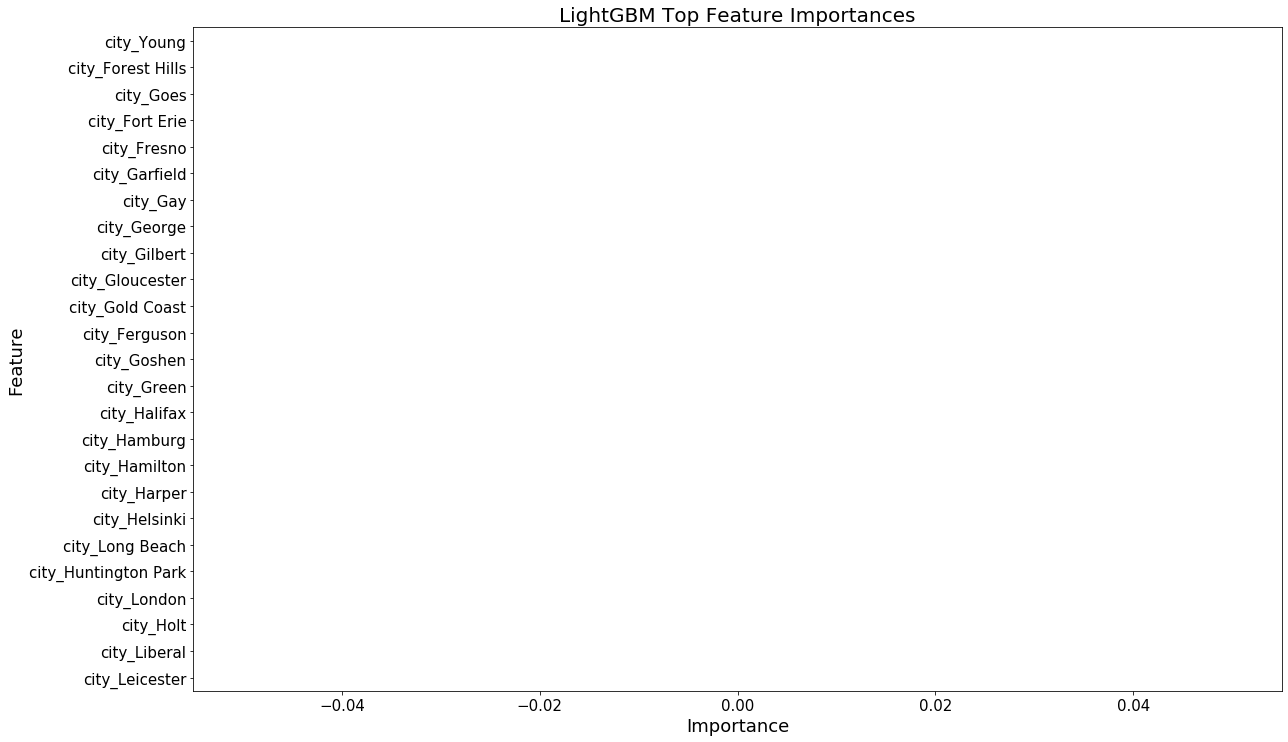

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_COUNTRY_ENCODED.CSV

             feature           importance

          country_IN		                  30
          country_ID		                  24
          country_AU		                  23
          country_BR		                  23
          country_CA		                  20
          country_NG		                  19
          country_ZA		                  18
          country_US		                  18
          country_GB		                  18
          country_PH		                  17
          country_NE		                  16
          country_JE		                  14
          country_KE		                  14
          country_CU		                  12
          country_IE		                  12
          country_AR		                   0
          country_EC		                   0
          country_DM		                   0
          country_ZW		                   0
          country_BG		                   0
          country_BE		                   0
          country_BH		  

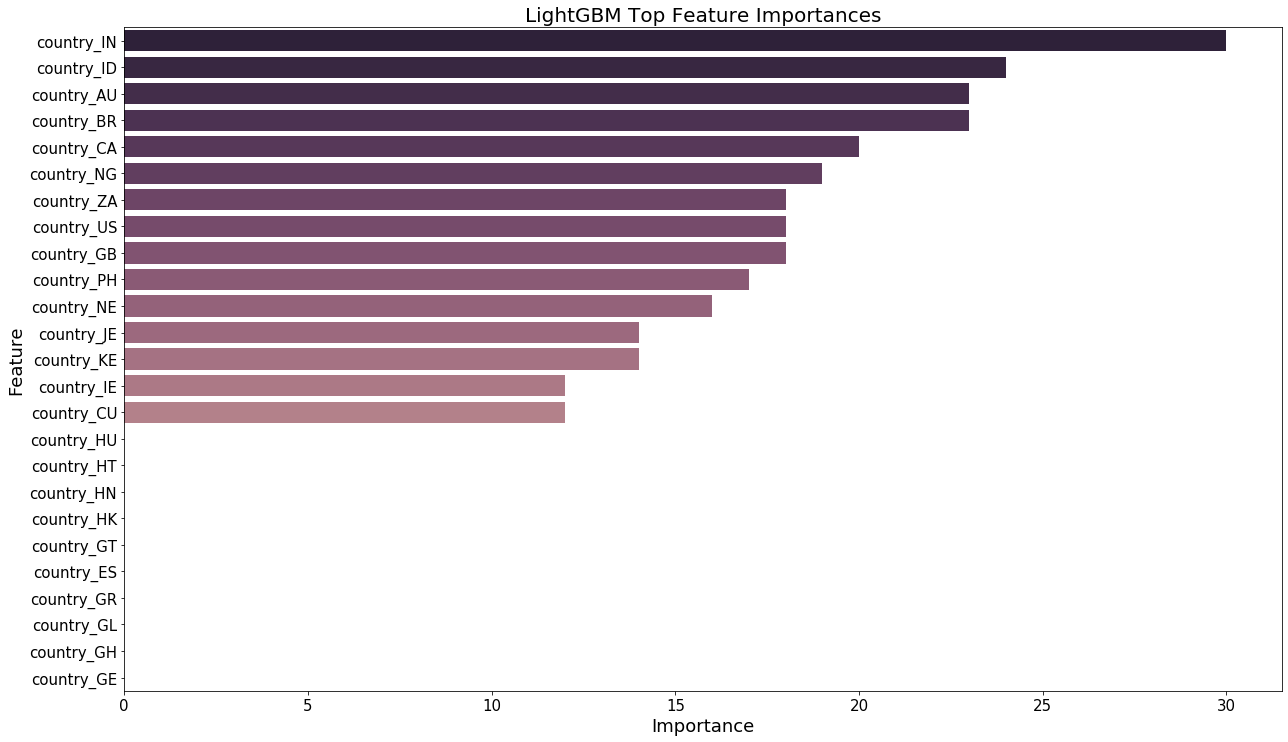

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_COUNTRY_IN_TEXT_ENCODED.CSV

             feature           importance

          country_PK		                  65
          country_GB		                  62
          country_MY		                  61
          country_TR		                  59
          country_IN		                  55
          country_IL		                  55
          country_CA		                  55
          country_US		                  52
          country_CN		                  52
          country_JP		                  49
          country_OM		                  38
          country_BE		                   0
          country_BG		                   0
          country_BH		                   0
          country_FI		                   0
          country_DM		                   0
          country_BI		                   0
          country_IT		                   0
          country_EG		                   0
          country_BB		                   0
          country_DZ		                   0
          countr

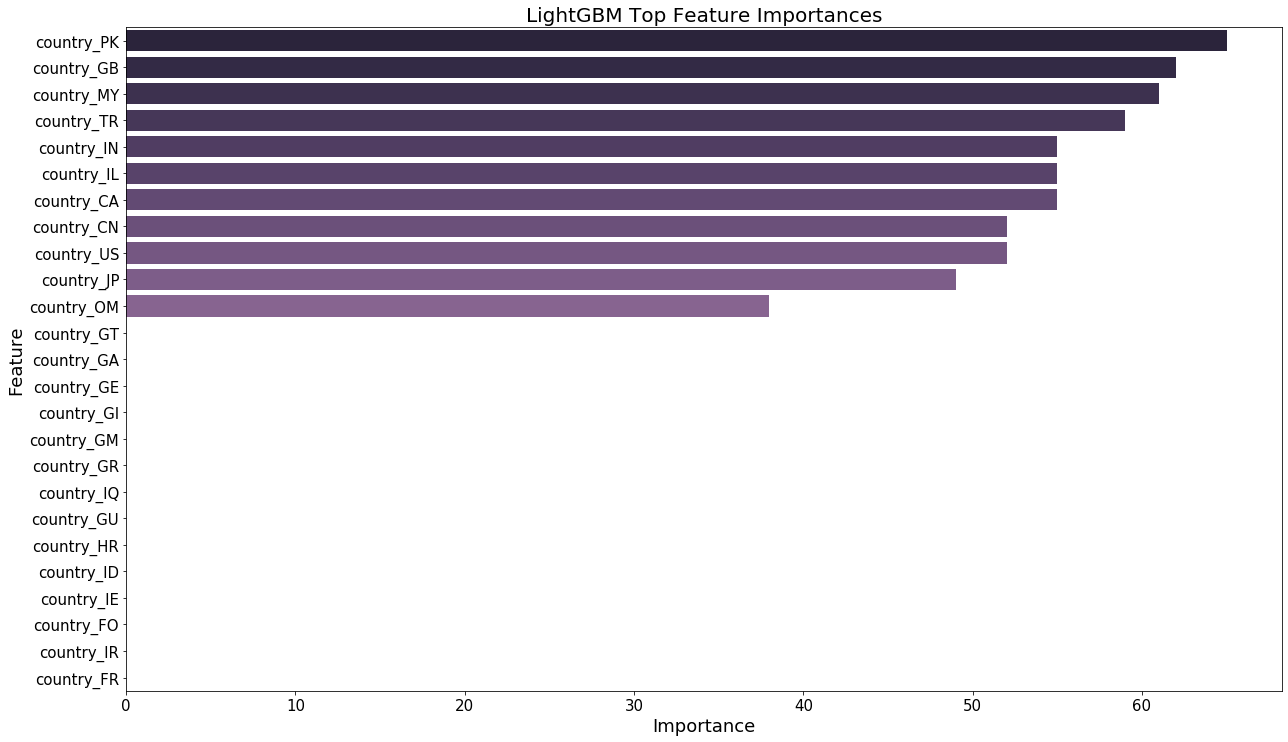

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_COUNTY_ENCODED.CSV

             feature           importance

county_Walker County		                   0
county_Shelby County		                   0
county_Sevier County		                   0
county_Rockland County		                   0
county_Palm Beach County		                   0
county_Orange County		                   0
county_Montgomery County		                   0
county_Milwaukee County		                   0
county_Harris County		                   0
county_Hanover County		                   0
county_Hamilton County		                   0
county_Charlotte County		                   0
  county_Carson City		                   0
 county_Bucks County		                   0
county_Bartholomew County		                   0





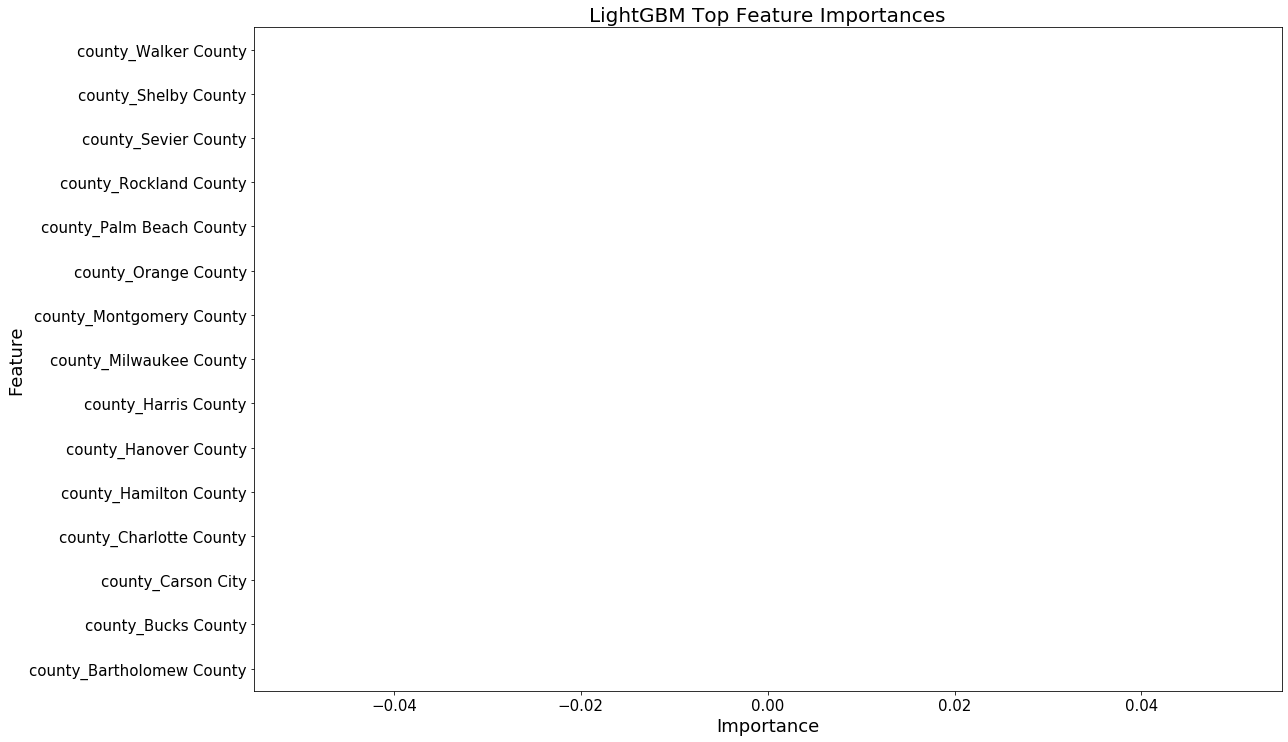

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_COUNTY_IN_TEXT_ENCODED.CSV

             feature           importance

county_Westchester County		                   0
county_Lowndes County		                   0
county_Chippewa County		                   0
county_Cuyahoga County		                   0
county_Davidson County		                   0
county_Fairfax County		                   0
         county_Guam		                   0
county_Halifax County		                   0
county_Harris County		                   0
  county_Kern County		                   0
  county_Lake County		                   0
 county_Logan County		                   0
county_Madison County		                   0
 county_Wayne County		                   0
 county_Marin County		                   0
county_Oklahoma County		                   0
county_Palm Beach County		                   0
county_Person County		                   0
county_Pickens County		                   0
 county_Salem County		                   0
county_Shelby County		                

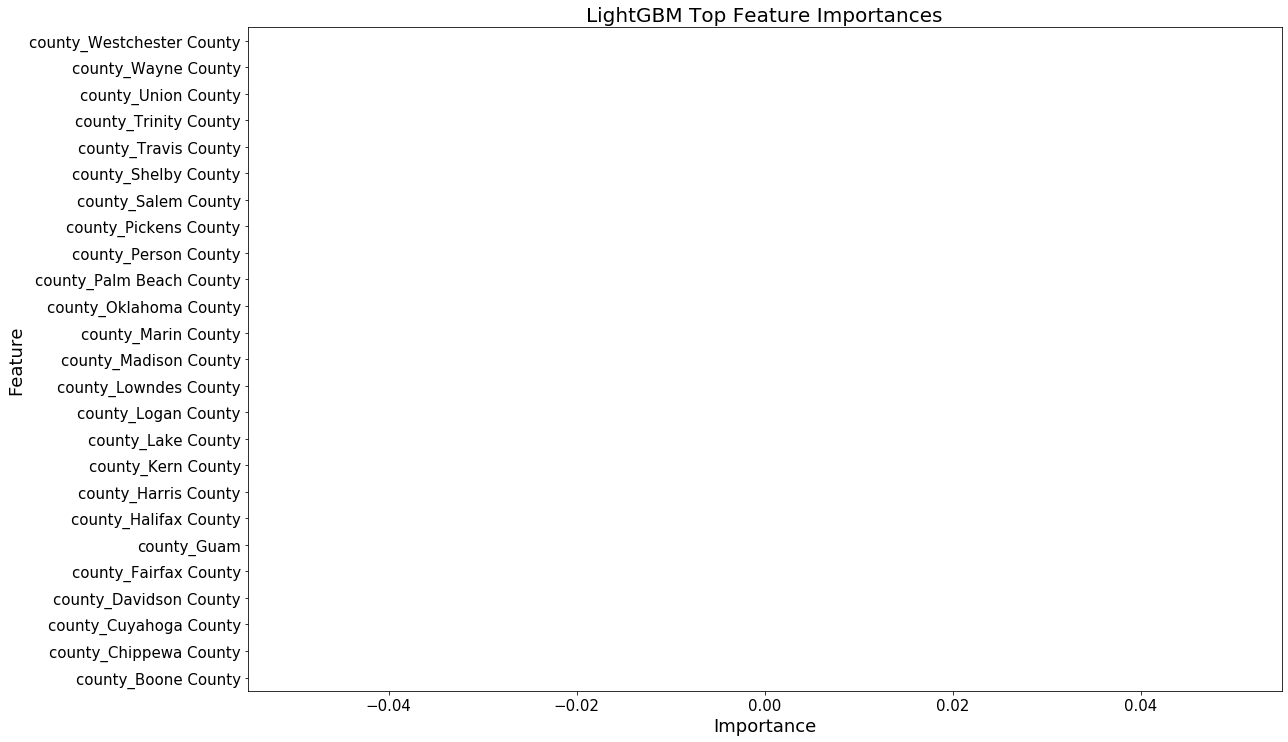

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_STATE_ENCODED.CSV

             feature           importance

         state_Texas		                  68
    state_Washington		                  53
       state_Florida		                  46
        state_Oregon		                  36
    state_California		                  25
     state_Minnesota		                   0
            state_MD		                   0
          state_Iowa		                   0
            state_KS		                   0
            state_KY		                   0
        state_Kansas		                   0
      state_Kentucky		                   0
     state_Louisiana		                   0
            state_UT		                   0
            state_AL		                   0
            state_MO		                   0
      state_Illinois		                   0
            state_MS		                   0
         state_Maine		                   0
      state_Maryland		                   0
 state_Massachusetts		                   0
       state_Indiana		    

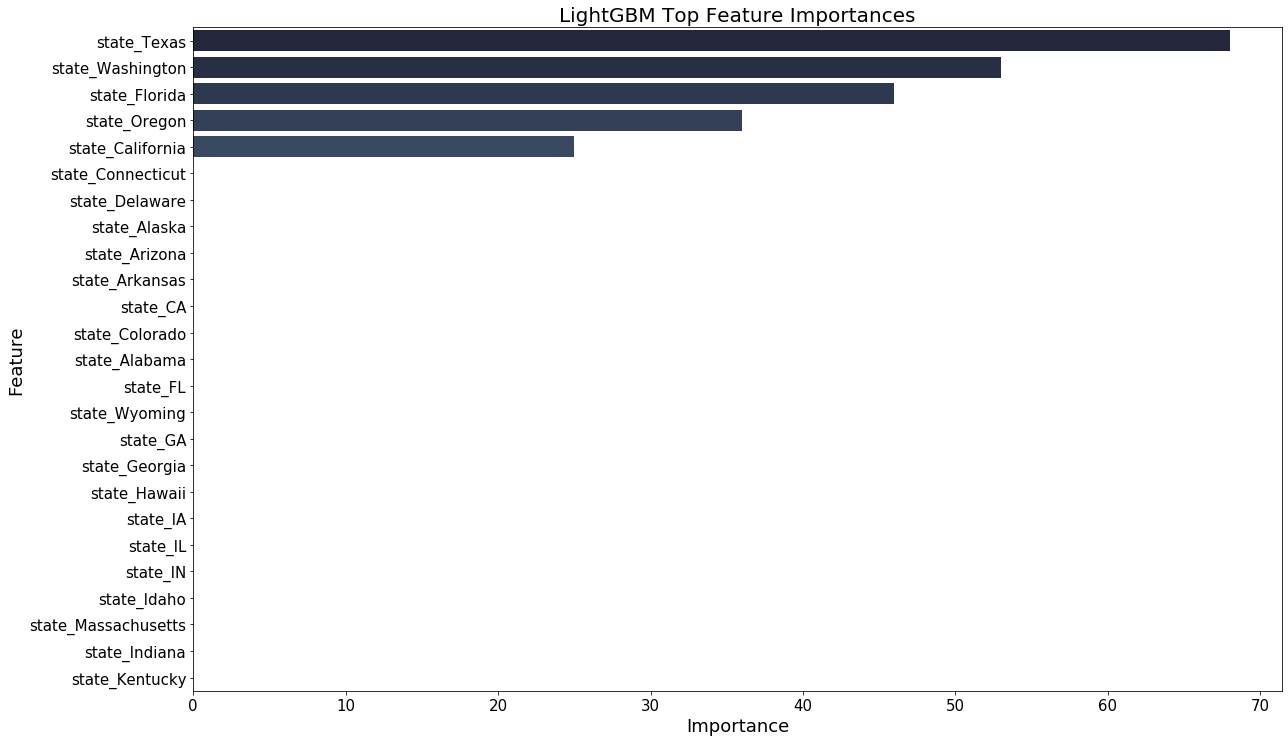

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_STATE_IN_TEXT_ENCODED.CSV

             feature           importance

    state_California		                 190
     state_Wisconsin		                   0
            state_MT		                   0
            state_KS		                   0
            state_KY		                   0
        state_Kansas		                   0
            state_MI		                   0
            state_MN		                   0
            state_MO		                   0
            state_MS		                   0
         state_Maine		                   0
      state_Illinois		                   0
            state_AR		                   0
            state_AL		                   0
   state_Mississippi		                   0
  state_South Dakota		                   0
            state_TN		                   0
            state_PA		                   0
  state_Rhode Island		                   0
       state_Indiana		                   0
         state_Idaho		                   0
       state_Alaba

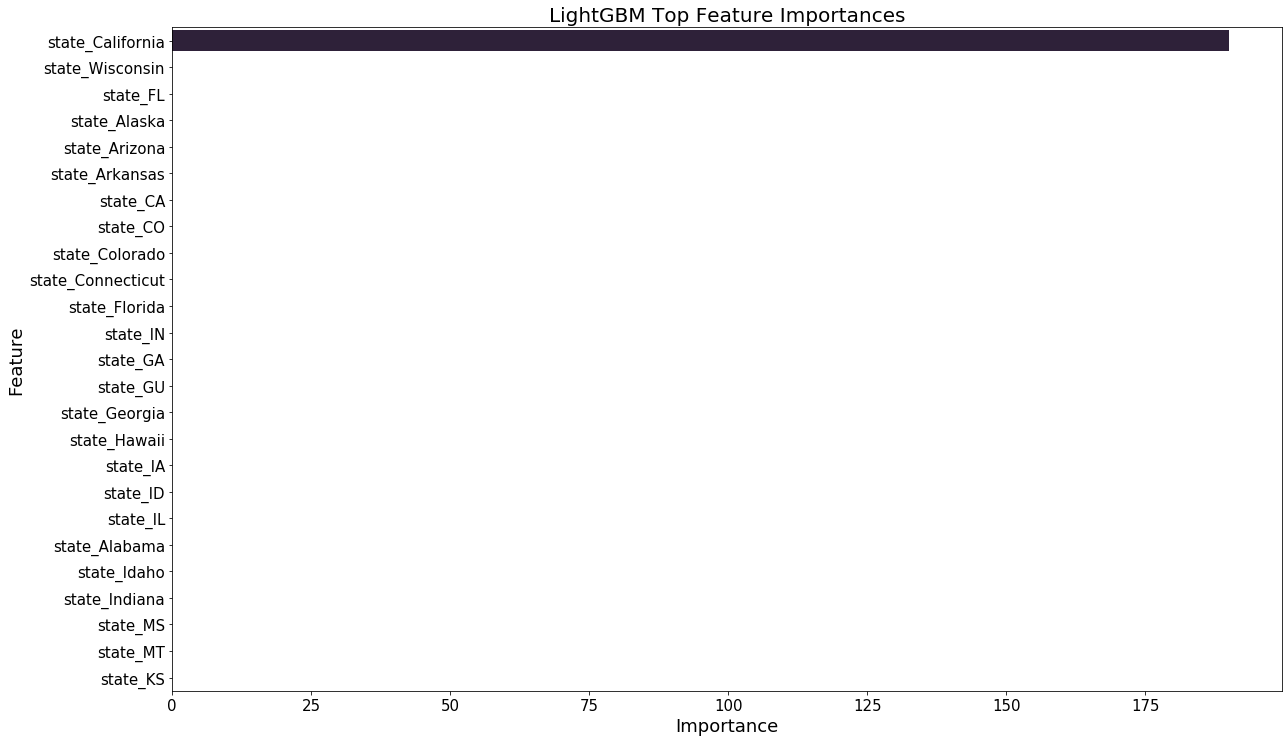

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_CONTINENT_ENCODED.CSV

             feature           importance

        continent_NA		                  10
        continent_AS		                  10
        continent_AF		                   9
        continent_OC		                   8
        continent_SA		                   5
        continent_EU		                   5
        continent_AN		                   0





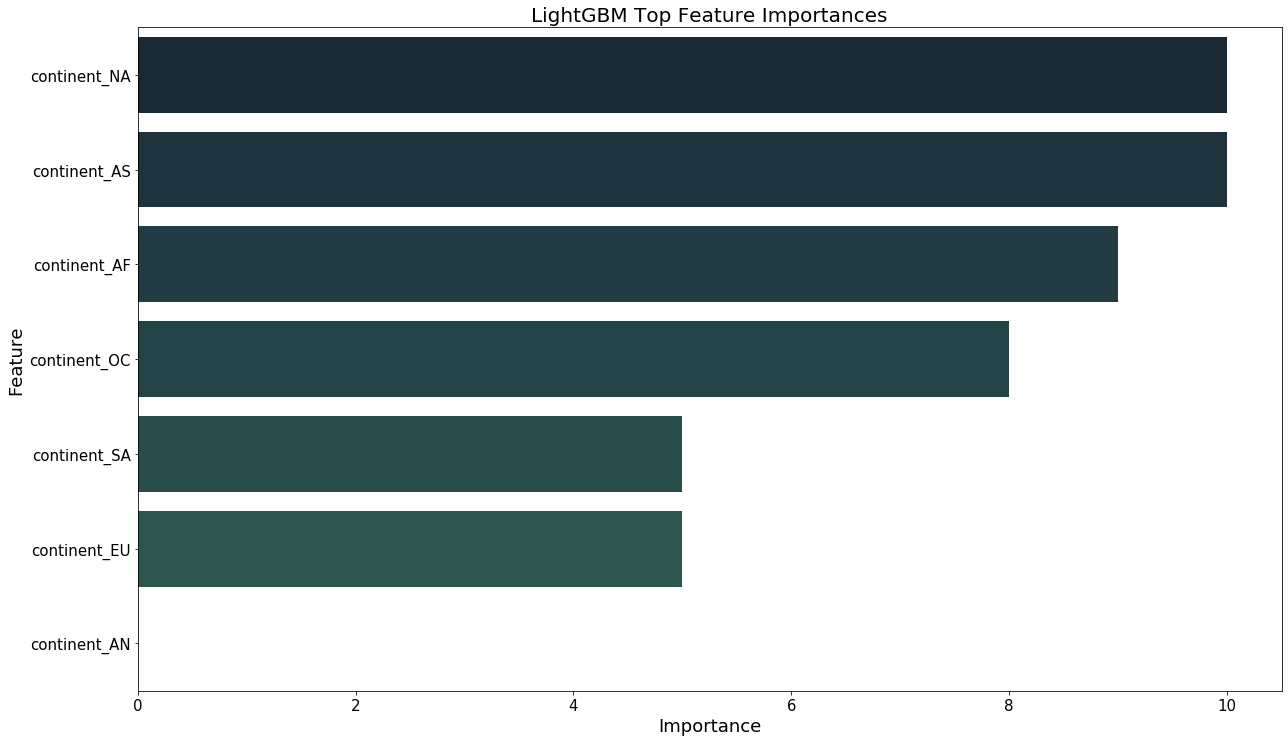

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_CONTINENT_IN_TEXT_ENCODED.CSV

             feature           importance

        continent_EU		                  78
        continent_AS		                  70
        continent_OC		                  68
        continent_NA		                  67
        continent_AF		                  44
        continent_SA		                   0





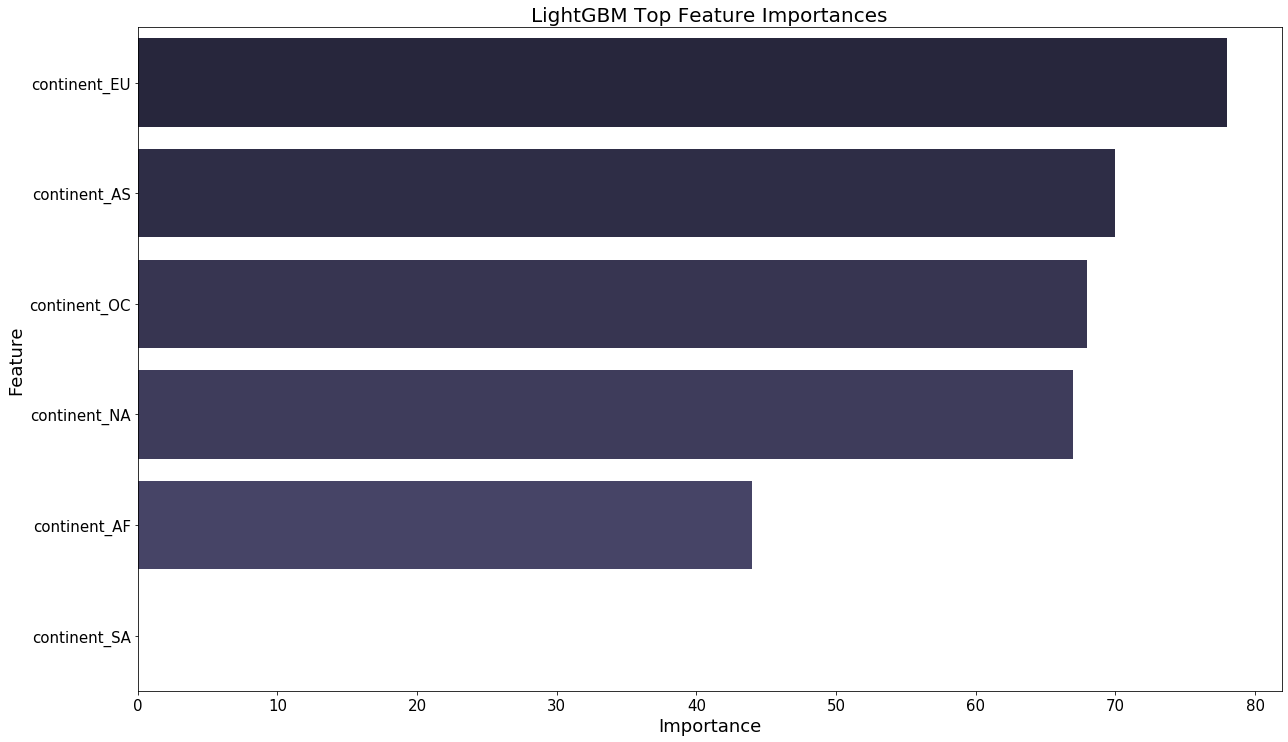

In [267]:
files_location_places = ['features_city_encoded.csv',
    'features_city_in_text_encoded.csv',
    'features_country_encoded.csv',
    'features_country_in_text_encoded.csv',
    'features_county_encoded.csv',
    'features_county_in_text_encoded.csv',
    'features_state_encoded.csv',
    'features_state_in_text_encoded.csv',
    'features_continent_encoded.csv',
    'features_continent_in_text_encoded.csv']

LGB_location_places = lightgbm_regressor_files(DIR_CSV + 'train/' , files_location_places, m)

## 4. Links

In [269]:
files_links = ['features_links_numerical.csv', "features_domain_bow.csv", "features_domain_tf_idf.csv", "features_domain_smooth_tf_idf.csv"]
LGB_links = lightgbm_regressor_files(DIR_CSV + 'train/' , files_links, m)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   37.3s finished


ValueError: Found input variables with inconsistent numbers of samples: [3185, 7613]

## 5. Tags

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_TAGS_BOW.CSV

             feature           importance

           tag_death		                  11
        tag_casualty		                  11
           tag_storm		                  11
         tag_refugee		                  11
           tag_flood		                  11
         tag_airport		                  11
          tag_famine		                  10
            tag_heat		                  10
          tag_hijack		                  10
          tag_atomic		                  10
           tag_spill		                  10
        tag_sinkhole		                  10
      tag_evacuation		                  10
         tag_rioting		                  10
         tag_bombing		                  10
        tag_wreckage		                  10
       tag_emergency		                  10
       tag_hazardous		                  10
        tag_attacked		                   9
       tag_explosion		                   9
     tag_anniversary		                   9
           tag_blast		         

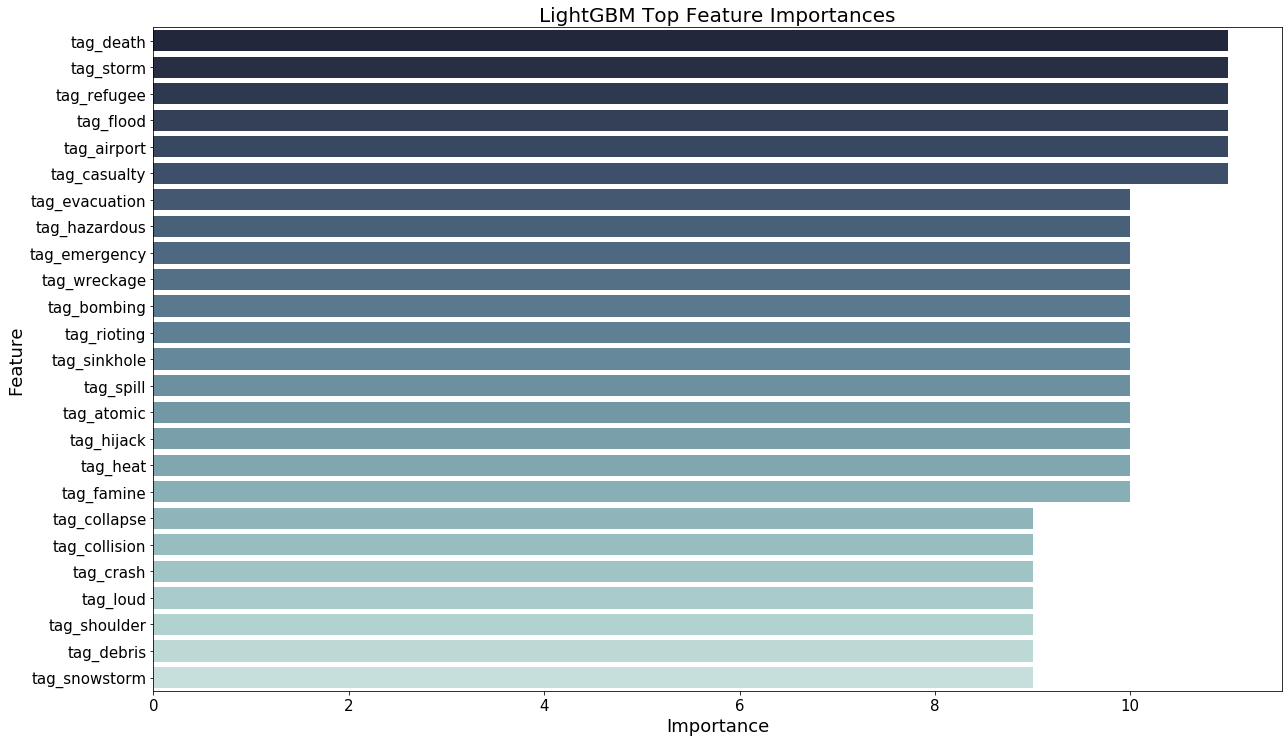

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


FEATURES_TAGS_TF_IDF.CSV

             feature           importance

        tag_building		                  12
           tag_storm		                  11
           tag_death		                  11
          tag_attack		                  10
          tag_forest		                   9
           tag_crash		                   9
        tag_casualty		                   9
       tag_emergency		                   9
         tag_migrant		                   8
        tag_wildfire		                   8
         tag_hostage		                   8
       tag_hiroshima		                   8
        tag_disaster		                   8
           tag_flood		                   7
         tag_nuclear		                   7
           tag_flame		                   6
        tag_collapse		                   6
           tag_train		                   6
         tag_typhoon		                   6
       tag_terrorism		                   6
      tag_evacuation		                   6
         tag_suicide		      

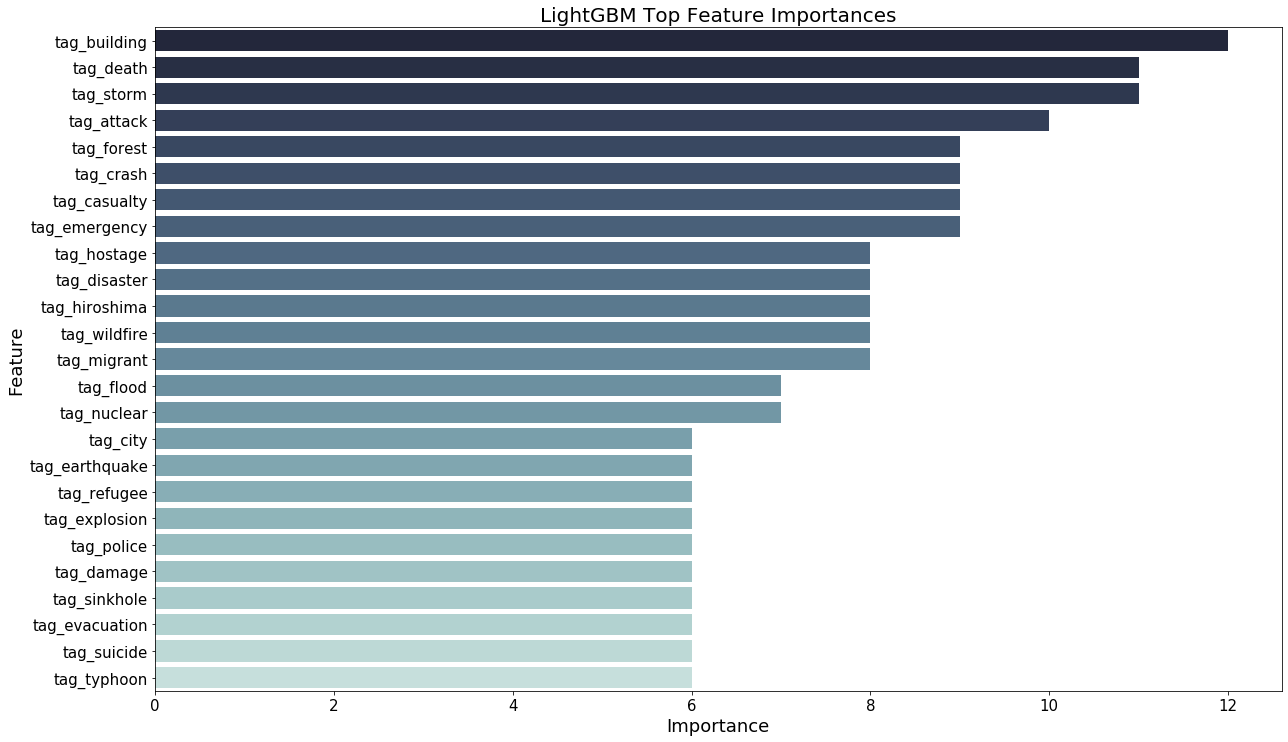

In [270]:
files_tags = ["features_tags_bow.csv", "features_tags_tf_idf.csv"]
LGB_tags = lightgbm_regressor_files(DIR_CSV + 'train/' , files_tags, m)

# IV) Conclusion